In [13]:
using CSV, DataFrames
df = CSV.read("../data/race_dataset.csv", DataFrame)

Row,box,odds,slit_score,horse
,Int64,Float64,Float64,String31
1,2,4.7,1.0,ブラウンラチェット
2,1,15.6,0.498544,ミストレス
3,8,4.1,0.498544,ショウナンザナドゥ
4,4,6.6,0.353499,シホリーン
5,3,6.3,0.296296,マイエレメント
6,10,3.1,0.245623,カムニャック
7,6,57.9,0.125,マピュース
8,11,79.9,0.0251356,クレオズニードル
9,5,13.4,0.00201291,ミリオンローズ


Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/tau/.julia/packages/Turing/NQDYt/src/mcmc/hmc.jl:207
Sampling   0%|▎                                         |  ETA: 0:03:21
Sampling   1%|▍                                         |  ETA: 0:01:40
Sampling   1%|▋                                         |  ETA: 0:01:07
Sampling   2%|▊                                         |  ETA: 0:00:50
Sampling   2%|█                                         |  ETA: 0:00:40
Sampling   3%|█▏                                        |  ETA: 0:00:33
Sampling   3%|█▍                                        |  ETA: 0:00:28
Sampling   4%|█▋                                        |  ETA: 0:00:25
Sampling   4%|█▊                                        |  ETA: 0:00:22
Sampling   5%|██                                        |  ETA: 0:00:20
Sampling   5%|██▏                                       |  ETA: 0:00:18
Sampling   6%|

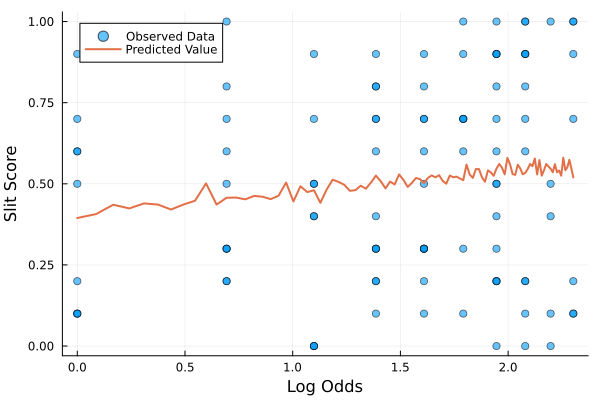

In [19]:
using Turing
using Distributions
using StatsPlots
using Random
using DataFrames

# サンプルデータを作成
Random.seed!(42)
df = DataFrame(odds=rand(1:10, 100), slit_score=rand(0.0:0.1:1.0, 100))

@model function liner_slit_score_model(odds, slit_score)
    α ~ Normal(0.5, 0.5)    # 切片
    β ~ Normal(0, 0.5)      # 傾き
    σ ~ Exponential(1)      # ノイズの標準偏差
    μ = α .+ β .* log.(odds) # 推定されるslit_scoreの平均値
    slit_score ~ MvNormal(μ, σ^2)
end

# モデルのサンプリング
model = liner_slit_score_model(df.odds, df.slit_score)
chain = sample(model, NUTS(), 1000)

# 予測区間の計算
odds_range = range(minimum(df.odds), maximum(df.odds), length=100)
log_odds_range = log.(odds_range)

# サンプルからパラメータを取得
α_samples = chain[:α]
β_samples = chain[:β]
σ_samples = chain[:σ]

# 予測分布の生成
predictions = [
    mean(α_samples .+ β_samples .* log_odds + rand(Normal(0, mean(σ_samples)), length(α_samples)))
    for log_odds in log_odds_range
]

# プロット
plot(log.(df.odds), df.slit_score,
    seriestype=:scatter,
    label="Observed Data",
    xlabel="Log Odds",
    ylabel="Slit Score",
    alpha=0.6
)
plot!(log_odds_range, predictions, label="Predicted Value", linewidth=2)

